# Выпускной проект "Промышленность"

Извлечем данные, произведем анализ и сформируем план работ:

In [1]:
import pandas as pd
import copy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta
from pandas import DataFrame
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from matplotlib import pyplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Для проверки на сервере

#data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
#data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
#data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
#data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
#data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
#data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
#data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [4]:
data_arc = pd.read_csv('C:\\Users\\ye-ye\\Datas\\Final\\data_arc.csv')
data_bulk = pd.read_csv('C:\\Users\\ye-ye\\Datas\\Final\\data_bulk.csv')
data_bulk_time = pd.read_csv('C:\\Users\\ye-ye\\Datas\\Final\\data_bulk_time.csv')
data_gas = pd.read_csv('C:\\Users\\ye-ye\\Datas\\Final\\data_gas.csv')
data_temp = pd.read_csv('C:\\Users\\ye-ye\\Datas\\Final\\data_temp.csv')
data_wire = pd.read_csv('C:\\Users\\ye-ye\\Datas\\Final\\data_wire.csv')
data_wire_time = pd.read_csv('C:\\Users\\ye-ye\\Datas\\Final\\data_wire_time.csv')

## Данные об электродах

In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
data_arc.describe().T

,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


In [7]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [8]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Добавляем новый столбец - общее время нагрева электродов, а ткже общую активную и реактивную мощность по каждому из этапов.

In [9]:
# Переводим тип столбцов из объекта в дату
data_arc['Datetime_begin'] = data_arc['Начало нагрева дугой'].apply(lambda _: datetime.strptime(_,"%Y-%m-%d %H:%M:%S"))
data_arc['Datetime_end'] = data_arc['Конец нагрева дугой'].apply(lambda _: datetime.strptime(_,"%Y-%m-%d %H:%M:%S"))
# Вычисляем длительность нагрева
data_arc['duration'] = data_arc['Datetime_end'] - data_arc['Datetime_begin']
data_arc['duration'] = pd.TimedeltaIndex(data_arc['duration']).seconds
# Формируем базу с нужными нам столбцами
data_duration = copy.deepcopy(data_arc)
data_duration = data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой' , 
                               'Активная мощность', 'Реактивная мощность', 'Datetime_begin', 'Datetime_end'], axis=1)

In [10]:
# Даем столбцам корректные имена
data_arc_active = (data_arc.groupby('key')[['Активная мощность']].sum()
                   .rename({'Активная мощность': 'active_power'}, axis=1))
data_arc_reactive = (data_arc.groupby('key')[['Реактивная мощность']].sum()
                     .rename({'Реактивная мощность': 'reactive_power'}, axis=1))
data_arc_iteration = (data_arc.groupby('key')[['Активная мощность']].count()
                      .rename({'Активная мощность': 'Iterations'}, axis=1))

# Вычисляем длительность по периодам
data_duration = data_duration.groupby('key')[['duration']].sum()

Поскольку нагревание дуги может быть разного времени в зависимости от потребности, то данные по началу и окончанию нагрева в работе можно исключить. Также при проведении предобработки данных будут исключены отрицательные значения.

In [11]:
# Объединяем базы
data_arc_power = pd.merge(data_arc_active, data_arc_reactive, how= 'left', on='key')
data_arc_power_iteration = pd.merge(data_arc_power, data_arc_iteration, how= 'left', on='key')
data_arc_up = pd.merge(data_arc_power_iteration, data_duration, how= 'left', on='key')

# Избавляемся от пропусков и дубликатов
data_arc_up = data_arc_up.dropna()
data_arc_up.drop_duplicates(inplace = True)
data_arc_up['key'] = data_arc_up.index
data_arc_up.index.name = None

In [12]:
# Делаем проверку на отрицательные показатели, исключаем их
print(data_arc_up[data_arc_up['active_power'] < 0])
print(data_arc_up[data_arc_up['reactive_power'] < 0])

Empty DataFrame
Columns: [active_power, reactive_power, Iterations, duration, key]
Index: []
      active_power  reactive_power  Iterations  duration   key
2116      1.848681     -714.591636           4       433  2116


In [13]:
data_arc_up = data_arc_up[data_arc_up['reactive_power'] >= 0]

Данные об электродах готовы к работе.

In [14]:
display(data_arc_up.head())

,active_power,reactive_power,Iterations,duration,key
1,4.878147,3.183241,5,1098,1
2,3.052598,1.998112,4,811,2
3,2.525882,1.599076,5,655,3
4,3.209250,2.060298,4,741,4
5,3.347173,2.252643,4,869,5


## Данные о подаче сыпучих материалов (объём)

In [15]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
data_bulk.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


In [17]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


В данной таблице очень мало данных. Столбцы с малым количеством признаков будут удалены (менее 1/3). В столбцах с более 1000 признаков пропуски будут заполнены нулями (тестирование моделей показало, что этот вариант благоприятниее заполнения средними значениями)

In [18]:
# Формируем базу, исключаем пропуски и дубликаты
data_bulk_up = copy.deepcopy(data_bulk)

data_bulk_up.fillna(0, inplace=True)
data_bulk_up.drop_duplicates(inplace = True)

data_bulk_up = data_bulk_up.drop(['Bulk 1', 'Bulk 2' , 'Bulk 5', 'Bulk 7', 
                                  'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13'], axis=1)

Данные о подаче сыпучих материалов (объём) готовы к работе.

In [19]:
data_bulk_up.head()

,key,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,43.0,0.0,206.0,150.0,154.0
1,2,0.0,73.0,0.0,206.0,149.0,154.0
2,3,0.0,34.0,0.0,205.0,152.0,153.0
3,4,0.0,81.0,0.0,207.0,153.0,154.0
4,5,0.0,78.0,0.0,203.0,151.0,152.0


## Данные о подаче сыпучих материалов (время)

In [20]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [21]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


В данной задаче время не учитывается для снижение температуры, данные не используем.

## Данные о продувке сплава газом

In [22]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [23]:
data_gas.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


In [24]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Используем данные в предложенном виде.

In [25]:
# Формируем базу, исключаем пропуски и дубликаты, даем корректное название столбцу
data_gas_up = copy.deepcopy(data_gas)
data_gas_up.drop_duplicates(inplace = True)
data_gas_up = data_gas_up.rename({'Газ 1': 'gas'}, axis=1)

Данные о продувке сплава газом готовы к работе.

## Результаты измерения температуры

In [26]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [27]:
data_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
key,15907.0,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
Температура,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


In [28]:
# Группируем по этапам, даем корректные названия
data_temp_first = data_temp.groupby('key')[['Температура']].first().rename({'Температура': 'temp_first'}, axis=1)
data_temp_last = data_temp.groupby('key')[['Температура']].last().rename({'Температура': 'temp_last'}, axis=1)

Время замера не используем, признаки с отсутствием значения "Температура" исключаем, т.к. это целевой признак. Добавляем отдельно признак - начальная температура.

In [29]:
# Объединяем базы
data_temp_up = pd.merge(data_temp_first, data_temp_last, how= 'left', on='key')

# Убираем пропуски и дубликаты
data_temp_up = data_temp_up.dropna()
data_temp_up['key'] = data_temp_up.index
data_temp_up.drop_duplicates(inplace = True)
data_temp_up.index.name = None

# Исключаем данные, где показатели начальной температуры совпадают с показателем конечной
data_temp_up = data_temp_up.drop(data_temp_up[data_temp_up['temp_first'] == data_temp_up['temp_last']].index)

In [30]:
print(data_temp_up)

      temp_first  temp_last   key
1         1571.0     1613.0     1
2         1581.0     1602.0     2
3         1596.0     1599.0     3
4         1601.0     1625.0     4
5         1576.0     1602.0     5
...          ...        ...   ...
2495      1570.0     1591.0  2495
2496      1554.0     1591.0  2496
2497      1571.0     1589.0  2497
2498      1591.0     1594.0  2498
2499      1569.0     1603.0  2499

[2433 rows x 3 columns]


Результаты измерения температуры готовы к работе.

## Данные о проволочных материалах (объём)

In [31]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [32]:
data_wire.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442842,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


In [33]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Также исключаем столбцы где менее трети значений признаков. Пропуски заменяем на нули.

In [34]:
# Формируем базу, исключаем пропуски и дубликаты
data_wire_up = copy.deepcopy(data_wire)

data_wire_up.fillna(0, inplace=True)
data_wire_up.drop_duplicates(inplace = True)

data_wire_up = data_wire_up.drop(['Wire 3', 'Wire 4' , 'Wire 5', 'Wire 6', 
                                  'Wire 7', 'Wire 8', 'Wire 9'], axis=1)

Данные о подаче сыпучих материалов (объём)Данные о проволочных материалах (объём) готовы к работе.

In [35]:
display(data_wire_up.head())

,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


## Данные о проволочных материалах (время)

In [36]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [37]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


При построении модели время не учитываем, данные из этой таблицы не используем.</strong>

## План работ

<ol><li>Предобработка данных по каждой из используемых таблиц;</li>
    <li>Объединение таблиц по ключу "key" в общую базу данных (далее - БД);</li>
    <li>Деление БД на тренировочную, валидационную и тестовую выборки;</li>
    <li>Обучение и проверка модели "Линейная регрессия";</li>
    <li>Обучение и проверка модели "Решающее дерево" с циклом подбора параметра "max_depth";</li>
    <li>Обучение и проверка модели "Случайный лес" с циклом подбора параметра "n_estimators";</li>
    <li>Обучение и проверка модели "CatBoost";</li>
    <li>Обучение и проверка модели "LightGBM";</li>
    <li>Фиксация результатов на тестовой выборке: время обучения модели, метрика, выбор лучшей модели;</li>
    <li>Вывод по задаче.</li>
    </ol>

## Формирование общей базы данных

In [38]:
# Пошагово объединяем готовые базы данных по общему ключу "key"
result_arc = pd.merge(data_temp_up, data_arc_up, how= 'left', on='key')
result_gas = pd.merge(result_arc, data_gas_up, how= 'left', on='key')
result_bulk = pd.merge(result_gas, data_bulk_up, how= 'left', on='key')
result_wire = pd.merge(result_bulk, data_wire_up, how= 'left', on='key')
result_final = result_wire.drop(['key'], axis = 1).dropna()

In [39]:
result_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2292 entries, 0 to 2432
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp_first      2292 non-null   float64
 1   temp_last       2292 non-null   float64
 2   active_power    2292 non-null   float64
 3   reactive_power  2292 non-null   float64
 4   Iterations      2292 non-null   float64
 5   duration        2292 non-null   float64
 6   gas             2292 non-null   float64
 7   Bulk 3          2292 non-null   float64
 8   Bulk 4          2292 non-null   float64
 9   Bulk 6          2292 non-null   float64
 10  Bulk 12         2292 non-null   float64
 11  Bulk 14         2292 non-null   float64
 12  Bulk 15         2292 non-null   float64
 13  Wire 1          2292 non-null   float64
 14  Wire 2          2292 non-null   float64
dtypes: float64(15)
memory usage: 286.5 KB


In [40]:
display(result_final.head())

,temp_first,temp_last,active_power,reactive_power,Iterations,duration,gas,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
0,1571.0,1613.0,4.878147,3.183241,5.0,1098.0,29.749986,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000
1,1581.0,1602.0,3.052598,1.998112,4.0,811.0,12.555561,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000
2,1596.0,1599.0,2.525882,1.599076,5.0,655.0,28.554793,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000
3,1601.0,1625.0,3.209250,2.060298,4.0,741.0,18.841219,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000
4,1576.0,1602.0,3.347173,2.252643,4.0,869.0,5.413692,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456


In [41]:
result_final.shape

(2292, 15)

In [42]:
# Проверяем на мультиколлинеарность
corr = result_final.corr()
display(corr)

,temp_first,temp_last,active_power,reactive_power,Iterations,duration,gas,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
temp_first,1.000000,0.247703,-0.352140,-0.330175,-0.143948,-0.309734,0.037690,-0.104246,0.142940,-0.094881,-0.061343,-0.132588,-0.042145,0.207390,-0.084912
temp_last,0.247703,1.000000,0.288241,0.238110,0.178583,0.275404,0.058104,-0.036930,0.184348,-0.178644,0.264655,0.113542,0.265723,0.313275,-0.207295
active_power,-0.352140,0.288241,1.000000,0.958192,0.759439,0.978087,0.374309,0.111182,-0.032770,0.156264,0.475696,0.465446,0.332822,0.048280,0.055172
reactive_power,-0.330175,0.238110,0.958192,1.000000,0.754183,0.965320,0.356861,0.068275,-0.035048,0.146663,0.454184,0.430180,0.295162,0.013881,0.052543
Iterations,-0.143948,0.178583,0.759439,0.754183,1.000000,0.798240,0.404670,0.106525,-0.006334,0.155539,0.304949,0.334760,0.172433,0.137345,0.079920
duration,-0.309734,0.275404,0.978087,0.965320,0.798240,1.000000,0.397241,0.091370,-0.031132,0.165115,0.464375,0.461587,0.294529,0.052410,0.055442
gas,0.037690,0.058104,0.374309,0.356861,0.404670,0.397241,1.000000,0.057485,0.016863,0.140988,0.215632,0.269023,0.039033,0.115646,0.103677
Bulk 3,-0.104246,-0.036930,0.111182,0.068275,0.106525,0.091370,0.057485,1.000000,-0.294426,0.066883,0.018556,0.010834,-0.013429,0.040300,0.096414
Bulk 4,0.142940,0.184348,-0.032770,-0.035048,-0.006334,-0.031132,0.016863,-0.294426,1.000000,-0.250568,0.104026,-0.090422,0.102254,0.295303,-0.267168
Bulk 6,-0.094881,-0.178644,0.156264,0.146663,0.155539,0.165115,0.140988,0.066883,-0.250568,1.000000,-0.112500,0.176881,-0.110694,-0.233051,0.203725


При проверке мультиколлиниарности замечаем высокую корреляцию между показателями активной энергии, реаактивной энергии и длительностью. Сделал тестовый замер по наиболее успешной модели "Случайный лес". Получил следующие результаты:

Полная база. МАЕ: 5.95, МАЕ с методом k-fold: 6.05, время обучения: 3.28 сек.
База без признака "Реативная энергия" и "Длительность". МАЕ: 5.98, МАЕ с методом k-fold: 6.10, время обучения: 2.99 сек.

В связи с полученными результатами принял решение не исключать столбцы для достижения наилучшей метрики МАЕ. В случае необходимости экономия ресурсов следует исключить данные, корреляция которых более 0.8.

In [43]:
#result_final = result_final.drop(['reactive_power', 'duration'], axis=1)

## Деление на тренировочную и тестовую выборки

In [44]:
# Выделяем признаки и целевой признак, делим базы на обучающую и тестовую
target = result_final['temp_last']
features = result_final.drop('temp_last', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345, stratify = None)

In [45]:
display(features_train)

,temp_first,active_power,reactive_power,Iterations,duration,gas,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
1017,1596.0,3.524701,2.182382,5.0,859.0,0.016696,0.0,0.0,49.0,206.0,128.0,103.0,82.087197,0.000000
1016,1609.0,2.531455,1.732732,6.0,730.0,11.032071,0.0,0.0,90.0,205.0,114.0,106.0,118.263588,0.000000
2314,1562.0,3.567261,2.474679,4.0,945.0,8.870626,0.0,0.0,109.0,156.0,249.0,103.0,45.077759,40.203281
2031,1582.0,1.852366,1.483036,4.0,547.0,7.364942,0.0,134.0,0.0,0.0,0.0,0.0,110.073601,0.000000
131,1579.0,4.478430,2.974421,6.0,1023.0,7.017192,349.0,0.0,0.0,512.0,254.0,201.0,124.225914,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,1576.0,2.633950,1.911463,4.0,656.0,8.537627,0.0,104.0,0.0,0.0,111.0,55.0,90.068153,0.000000
582,1604.0,3.518445,2.517139,7.0,911.0,16.999932,0.0,0.0,0.0,205.0,145.0,102.0,86.158798,65.205919
418,1578.0,2.750730,2.047929,5.0,665.0,11.979637,0.0,121.0,0.0,264.0,137.0,223.0,140.680799,0.000000
2303,1540.0,3.257705,2.205600,4.0,774.0,7.716934,0.0,0.0,43.0,124.0,216.0,104.0,0.000000,100.674072


Применяем масштабирование признаков.

In [46]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_tr = scaler.transform(features_train)
features_test_tr = scaler.transform(features_test)

## Обучение моделей

Производим обучение нескольких моделей с подбором наиболее благоприятных параметров методом GridSearchCV(). Также находим МАЕ методом кросс-валидации.

### Обучение модели "Логистическая регрессия"

In [47]:
%%time

kfold = KFold(n_splits=10, random_state=12345, shuffle=True)

model_regression = LogisticRegression()
resultArr = cross_val_score(model_regression, features_train_tr, target_train, cv=kfold, scoring='neg_mean_absolute_error')

model_regression.fit(features_train_tr, target_train)
predicted_regression = model_regression.predict(features_test_tr)

print("MAE модели на тестовой выборке:", mean_absolute_error(target_test, predicted_regression))
print("Средняя метрика MAE модели:", -1 * resultArr.mean())

MAE модели на тестовой выборке: 6.230936819172113
Средняя метрика MAE модели: 7.082947255880256
Wall time: 5.42 s


Feature: 0, Score: 0.60659
Feature: 1, Score: -0.15106
Feature: 2, Score: -0.11537
Feature: 3, Score: 0.88552
Feature: 4, Score: -0.00727
Feature: 5, Score: 0.42195
Feature: 6, Score: -0.12405
Feature: 7, Score: 0.50023
Feature: 8, Score: -0.10215
Feature: 9, Score: -0.28468
Feature: 10, Score: -0.45018
Feature: 11, Score: -0.30478
Feature: 12, Score: -0.54518
Feature: 13, Score: -0.11505


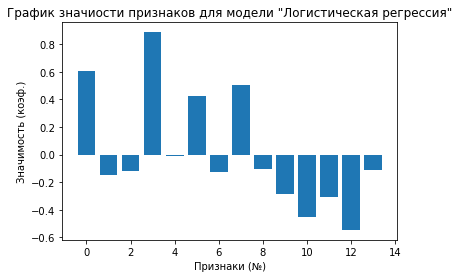

In [48]:
importance = model_regression.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
pyplot.bar([x for x in range(len(importance))], importance)

pyplot.title('График значиости признаков для модели "Логистическая регрессия"')
pyplot.xlabel('Признаки (№)')
pyplot.ylabel('Значимость (коэф.)')

pyplot.show()

Убираем малозначимые признаки:

In [49]:
features_train_clear = features_train.drop(['active_power', 'reactive_power' , 
                               'duration', 'Bulk 3', 'Bulk 15', 'Wire 2'], axis=1)
features_test_clear = features_test.drop(['active_power', 'reactive_power' , 
                               'duration', 'Bulk 3', 'Bulk 15', 'Wire 2'], axis=1)

In [50]:
# Масштабируем
scaler = StandardScaler()
scaler.fit(features_train_clear)
features_train_tr_clear = scaler.transform(features_train_clear)
features_test_tr_clear = scaler.transform(features_test_clear)

In [51]:
%%time

model_regression_clear = LogisticRegression()
resultArr = cross_val_score(model_regression, features_train_tr, target_train, cv=kfold, scoring='neg_mean_absolute_error')

model_regression_clear.fit(features_train_tr_clear, target_train)
predicted_regression = model_regression_clear.predict(features_test_tr_clear)

print("MAE модели на тестовой выборке:", mean_absolute_error(target_test, predicted_regression))
print("Средняя метрика MAE модели:", -1 * resultArr.mean())

MAE модели на тестовой выборке: 7.021786492374727
Средняя метрика MAE модели: 7.082947255880256
Wall time: 6.1 s


На примере модели "Логистическая регрессия" был проведен анализ малозначимых признаков. По результатам которого увеличилось время обучения модели с 4.6 сек. до 5.28 сек., показатель МАЕ показал более худший результат 7.02 против 6.23. Прианализе последующих моделей строил графики, но мало значимые признаки не исключал.

### Обучение модели "Решающее дерево"

In [52]:
%%time

clf = DecisionTreeRegressor()

parametrs = { 'max_depth': range (1,25, 2),
              'min_samples_leaf': range (1,18),
              'min_samples_split': range (2,20,2) }

grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train_tr, target_train)

grid.best_params_

Wall time: 1min 16s


{'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_split': 4}

In [53]:
%%time

kfold = KFold(n_splits=10, random_state=12345, shuffle=True)

model_tree = DecisionTreeRegressor(max_depth=7, min_samples_leaf=17, min_samples_split=2)
resultArr = cross_val_score(model_regression, features_train_tr, target_train, cv=kfold, scoring='neg_mean_absolute_error')

model_tree.fit(features_train_tr, target_train)
predicted_tree = model_tree.predict(features_test_tr)

print("MAE модели на тестовой выборке:", mean_absolute_error(target_test, predicted_tree))
print("Средняя метрика MAE модели:", -1 * resultArr.mean())

MAE модели на тестовой выборке: 6.335511081312417
Средняя метрика MAE модели: 7.082947255880256
Wall time: 4.81 s


Feature: 0, Score: 0.44319
Feature: 1, Score: 0.29387
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.01670
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.01783
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.10360
Feature: 9, Score: 0.00181
Feature: 10, Score: 0.02809
Feature: 11, Score: 0.02434
Feature: 12, Score: 0.04354
Feature: 13, Score: 0.02704


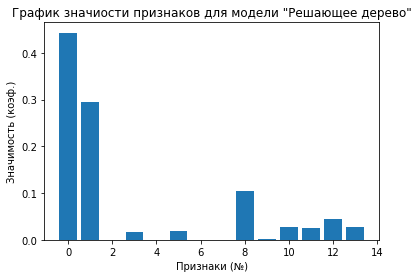

In [54]:
importance = model_tree.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

pyplot.bar([x for x in range(len(importance))], importance)

pyplot.title('График значиости признаков для модели "Решающее дерево"')
pyplot.xlabel('Признаки (№)')
pyplot.ylabel('Значимость (коэф.)')

pyplot.show()

Наиболее значимые признаки для модели 0, 1, 8, 11, 12, 13.

#### Обучение модели "Случайный лес"

In [55]:
%%time

clf = RandomForestRegressor()

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,25, 2),
              'min_samples_leaf': range (1,18),
              'min_samples_split': range (2,20,2) }

grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train_tr, target_train)

grid.best_params_

Wall time: 1h 57min 33s


{'max_depth': 13,
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 40}

In [56]:
%%time

kfold = KFold(n_splits=10, random_state=12345, shuffle=True)

model_forest = RandomForestRegressor(n_estimators= 40, max_depth=13, min_samples_leaf= 2, min_samples_split= 2)
resultArr = cross_val_score(model_forest, features_train_tr, target_train, cv=kfold, scoring='neg_mean_absolute_error')

model_forest.fit(features_train_tr, target_train)
predicted_forest = model_forest.predict(features_test_tr)

print("MAE модели на тестовой выборке:", mean_absolute_error(target_test, predicted_forest))
print("Средняя метрика MAE модели:", -1 * resultArr.mean())

MAE модели на тестовой выборке: 5.880139925836146
Средняя метрика MAE модели: 6.201075247346132
Wall time: 3.62 s


Feature: 0, Score: 0.25265
Feature: 1, Score: 0.16581
Feature: 2, Score: 0.04547
Feature: 3, Score: 0.02236
Feature: 4, Score: 0.06805
Feature: 5, Score: 0.06040
Feature: 6, Score: 0.02047
Feature: 7, Score: 0.01713
Feature: 8, Score: 0.07298
Feature: 9, Score: 0.04587
Feature: 10, Score: 0.04365
Feature: 11, Score: 0.04160
Feature: 12, Score: 0.10418
Feature: 13, Score: 0.03939


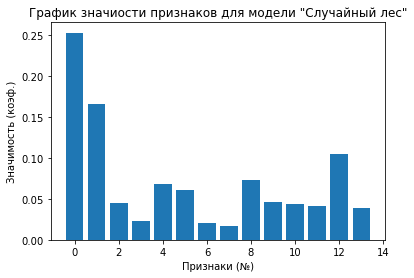

In [57]:
importance = model_forest.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

pyplot.bar([x for x in range(len(importance))], importance)

pyplot.title('График значиости признаков для модели "Случайный лес"')
pyplot.xlabel('Признаки (№)')
pyplot.ylabel('Значимость (коэф.)')

pyplot.show()

Наиболее значимые признаки для модели 0, 1, 2, 4, 5, 8, 9, 10, 12, 13.

### Обучение модели "CatBoost"

In [58]:
%%time

clf = CatBoostRegressor()

parametrs = { 'n_estimators': range (10, 51, 10),
              'depth': range (1,25, 2)}

grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train_tr, target_train)

grid.best_params_

Learning rate set to 0.5
0:	learn: 10.8112400	total: 151ms	remaining: 1.36s
1:	learn: 10.4685420	total: 154ms	remaining: 617ms
2:	learn: 10.2025016	total: 157ms	remaining: 365ms
3:	learn: 10.0646330	total: 159ms	remaining: 238ms
4:	learn: 9.8396829	total: 161ms	remaining: 161ms
5:	learn: 9.7052144	total: 162ms	remaining: 108ms
6:	learn: 9.5153402	total: 163ms	remaining: 70ms
7:	learn: 9.4301873	total: 164ms	remaining: 41.1ms
8:	learn: 9.2530127	total: 166ms	remaining: 18.5ms
9:	learn: 9.2071789	total: 167ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 11.0922261	total: 1.14ms	remaining: 10.2ms
1:	learn: 10.7491148	total: 2.29ms	remaining: 9.16ms
2:	learn: 10.4912631	total: 3.33ms	remaining: 7.76ms
3:	learn: 10.3518166	total: 4.35ms	remaining: 6.53ms
4:	learn: 10.1448486	total: 5.37ms	remaining: 5.37ms
5:	learn: 10.0282003	total: 6.4ms	remaining: 4.27ms
6:	learn: 9.8355756	total: 7.47ms	remaining: 3.2ms
7:	learn: 9.7503503	total: 8.59ms	remaining: 2.15ms
8:	learn: 9.5659304	total: 

{'depth': 5, 'n_estimators': 40}

In [59]:
%%time

kfold = KFold(n_splits=10, random_state=12345, shuffle=True)

model_cat = CatBoostRegressor(depth=5, n_estimators=40, learning_rate=1, loss_function='MAE', verbose=False)
resultArr = cross_val_score(model_cat, features_train_tr, target_train, cv=kfold, scoring='neg_mean_absolute_error')

model_cat.fit(features_train_tr, target_train)
predicted_cat = model_cat.predict(features_test_tr)

print("MAE модели на тестовой выборке:", mean_absolute_error(target_test, predicted_cat))
print("Средняя метрика MAE модели:", -1 * resultArr.mean())

MAE модели на тестовой выборке: 6.827878541462903
Средняя метрика MAE модели: 7.127394804122848
Wall time: 1.28 s


Feature: 0, Score: 19.54327
Feature: 1, Score: 15.50661
Feature: 2, Score: 4.49451
Feature: 3, Score: 2.75643
Feature: 4, Score: 14.42586
Feature: 5, Score: 4.82502
Feature: 6, Score: 2.44632
Feature: 7, Score: 1.42446
Feature: 8, Score: 8.90751
Feature: 9, Score: 3.40508
Feature: 10, Score: 3.57514
Feature: 11, Score: 3.55684
Feature: 12, Score: 6.55895
Feature: 13, Score: 8.57397


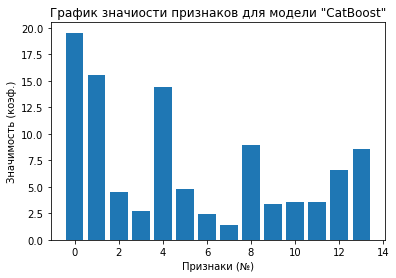

In [60]:
importance = model_cat.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

pyplot.bar([x for x in range(len(importance))], importance)

pyplot.title('График значиости признаков для модели "CatBoost"')
pyplot.xlabel('Признаки (№)')
pyplot.ylabel('Значимость (коэф.)')

pyplot.show()

Наиболее значимые признаки для модели 0, 1, 2, 8, 12, 13.

### Обучение модели "LightGBM"

In [61]:
%%time

clf = lgb.LGBMRegressor()

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,50, 2),
              'num_leaves': range (1,100, 2),
              'learning_rate': range (1, 10)}

grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(features_train, target_train)

grid.best_params_

Wall time: 4h 10min 34s


{'learning_rate': 1, 'max_depth': 1, 'n_estimators': 50, 'num_leaves': 3}

In [62]:
%%time

kfold = KFold(n_splits=10, random_state=12345, shuffle=True)

gbm = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=3, 
                        max_depth=- 1, learning_rate=1, 
                        n_estimators=50)
resultArr = cross_val_score(gbm, features_train_tr, target_train, cv=kfold, scoring='neg_mean_absolute_error')

gbm.fit(features_train_tr, target_train,
        eval_set=[(features_test_tr, target_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)
predicted_lgb = gbm.predict(features_test_tr, num_iteration=gbm.best_iteration_)

print("MAE модели на тестовой выборке:", mean_absolute_error(target_test, predicted_lgb))
print("Средняя метрика MAE модели:", -1 * resultArr.mean())

[1]	valid_0's l1: 7.62446	valid_0's l2: 111.663
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l1: 7.23192	valid_0's l2: 103.437
[3]	valid_0's l1: 6.90936	valid_0's l2: 100.891
[4]	valid_0's l1: 6.67317	valid_0's l2: 95.6102
[5]	valid_0's l1: 6.54925	valid_0's l2: 94.0746
[6]	valid_0's l1: 6.48385	valid_0's l2: 90.5354
[7]	valid_0's l1: 6.39867	valid_0's l2: 90.6183
[8]	valid_0's l1: 6.39137	valid_0's l2: 86.3911
[9]	valid_0's l1: 6.34665	valid_0's l2: 86.5352
[10]	valid_0's l1: 6.36704	valid_0's l2: 85.407
[11]	valid_0's l1: 6.30386	valid_0's l2: 82.7475
[12]	valid_0's l1: 6.27594	valid_0's l2: 80.9909
[13]	valid_0's l1: 6.27512	valid_0's l2: 81.4056
[14]	valid_0's l1: 6.21815	valid_0's l2: 80.394
[15]	valid_0's l1: 6.15483	valid_0's l2: 78.1179
[16]	valid_0's l1: 6.07836	valid_0's l2: 77.295
[17]	valid_0's l1: 6.06535	valid_0's l2: 76.0488
[18]	valid_0's l1: 6.10672	valid_0's l2: 79.5915
[19]	valid_0's l1: 6.11834	valid_0's l2: 80.0393
[20]	valid_0's l1:

Feature: 0, Score: 10.00000
Feature: 1, Score: 9.00000
Feature: 2, Score: 1.00000
Feature: 3, Score: 2.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 3.00000
Feature: 6, Score: 1.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 2.00000
Feature: 9, Score: 1.00000
Feature: 10, Score: 1.00000
Feature: 11, Score: 1.00000
Feature: 12, Score: 2.00000
Feature: 13, Score: 1.00000


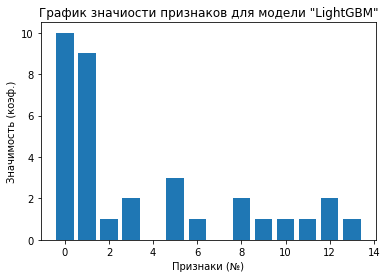

In [63]:
importance = gbm.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

pyplot.bar([x for x in range(len(importance))], importance)

pyplot.title('График значиости признаков для модели "LightGBM"')
pyplot.xlabel('Признаки (№)')
pyplot.ylabel('Значимость (коэф.)')

pyplot.show()

Наиболее значимые признаки для модели 0, 1, 2, 8, 11, 12, 13.

## Итог

Для получения модели необходимо было произвести тщательную предобработку данных. Из 7 предложенных таблиц были использованы 5. Данные с фиксацией временных промежутков задействованы не были.
<ul><li>Данные об электродах - произведена группировка по этапам, выделены дополнительные ризнаки</li>
    <li>Данные о подаче сыпучих материалов (объём) - исключены столбцы с низким количеством зафиксированных значений</li>
    <li>Данные о подаче сыпучих материалов (время) - данные не использовались</li>
    <li>Данные о продувке сплава газом - данные использованы в предложенном виде</li>
    <li>Результаты измерения температуры - извлечен дополнительный признак</li>
    <li>Данные о проволочных материалах (объём)- исключены столбцы с низким количеством зафиксированных значений</li>
    <li>Данные о проволочных материалах (время) - данные не использовались</li></ul>
Все данные были сгруппированы в общую таблицу признаков, выделен целевой признак (последний замер температуры по этапу), произведено масштабирование признаков.

Были обучены модели с предварительным подбором наиболее благоприятных гиперпараметров для достижения наилучшего показателя метрики МАЕ методом GridSearch() с той же целью к моделям был применен метод кросс-валидации. Зафиксировано время обучения.

In [64]:
df = pd.DataFrame(
    {
        'Модель': ['Логистическая регрессия', 'Решающее дерево', 'Случайный лес', 'CatBoost', 'LightGBM'],
        'Скорость обучения модели': ["4.06 s", "4.02 s", "3.68 s", "1.33 s", "0.23 s"],
        'MAE модели на тестовой выборке': [6.23, 6.33, 5.91, 6.83, 6.06], 
        'Средняя метрика MAE модели': [7.08, 7.08, 6.14, 7.13, 6.64], 
    })
      
display(df) 

,Модель,Скорость обучения модели,MAE модели на тестовой выборке,Средняя метрика MAE модели
0,Логистическая регрессия,4.06 s,6.23,7.08
1,Решающее дерево,4.02 s,6.33,7.08
2,Случайный лес,3.68 s,5.91,6.14
3,CatBoost,1.33 s,6.83,7.13
4,LightGBM,0.23 s,6.06,6.64


Исходя из полученных данных наилучшим образом показала себя модель "Случайный лес", достижение показателя МАЕ 5.91. Модель model_forest готова к предсказанию температуры на новых данных.

<strong>Какие ключевые шаги в решении задачи выделили?</strong>
<br><ul><li>Предобработка данных, включая извлечение новых признаков,</li>
    <li>Формирование общей базы признаков,</li>
    <li>Масштабирование,</li>
    <li>Проверка на мультиколлиниарность,</li>
    <li>Поиск наилучших параметров модели,</li>
    <li>Обучение модели, замер времени,</li>
    <li>Проверка на важность признаков,</li>
    <li>Сравнение результатов нескольких моделей.</li></ul>